# AE8803 Final Project

Author: Teo Wilkening

Class: AE8803 Machine Learning with Gaussian Processes

Due Date: 2024-05-03

This notebook has been built to show the real-time processing of
pressure readings received from a pressure sensor and pitot tube
attached to the Jetbot robot.

The goals of this project are:
1. Build a GP to predict the upcoming pressure readings.
2. Graphically display the GP predictions vs. observations.
3. Update the GP model at a specified interval based on observations.

Below is the data flow architecture that has been implemented to achieve the above
goals. Supporting files are attached in the submission and may be found on
GitHub: [ae8803/Final_Project](https://github.com/twilkening/ae8803/tree/main/Final_Project)

![diagram of the flow of data during processing](diagrams/data_flow.jpg)

## Package Imports

In [1]:
%matplotlib widget
import subprocess
import time
import matplotlib.pyplot as plt
import numpy as np
import logging
import psycopg2
import torch
import sys

if sys.platform == "win32":
    sys.path.insert(
        0,
        "C:\\Users\\twilkeni\\AppData\\Local"
        + "\\anaconda3\\envs\\pytorch-env\\site-packages",
    )
import gpytorch
from config import load_config
import PLOT

logger = logging.getLogger(__name__)
FORMAT = "[%(filename)s:%(lineno)s - %(funcName)20s() ] %(asctime)s : %(message)s"
logging.basicConfig(
    filename="logs/notebook.log", filemode="w", format=FORMAT, level=logging.DEBUG, datefmt='%Y-%m-%d %H:%M:%S'
)

In [13]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
import numpy as np
import time

output_notebook()  # This embeds the Bokeh plot within the JupyterLab notebook


Loading BokehJS ...

In [14]:
x = np.linspace(0, 2 * np.pi, 100)
y = np.sin(x)
source = ColumnDataSource(data={'x': x, 'y': y})

plot = figure(title='Dynamic Sine Wave', plot_height=300, plot_width=600)
plot.line('x', 'y', source=source)
handle = show(plot, notebook_handle=True)


In [17]:
for i in range(100):
    y = np.sin(x + i / 10.0)
    source.data = {'x': x, 'y': y}  # Update the data in the ColumnDataSource
    push_notebook(handle=handle)  # Push updates to the plot
    time.sleep(1)  # Pause to allow observation of changes



KeyboardInterrupt: 

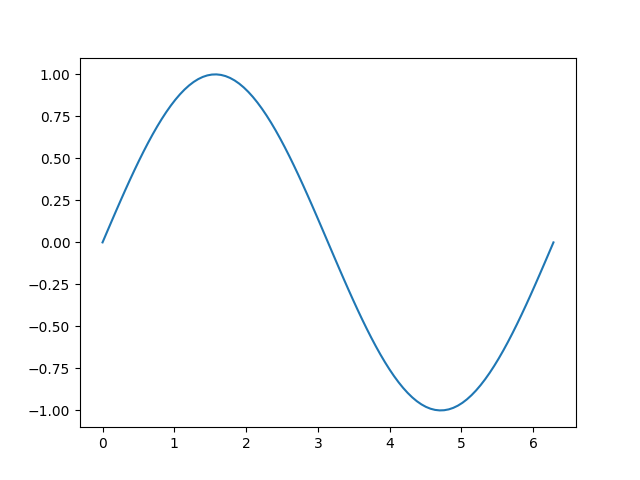

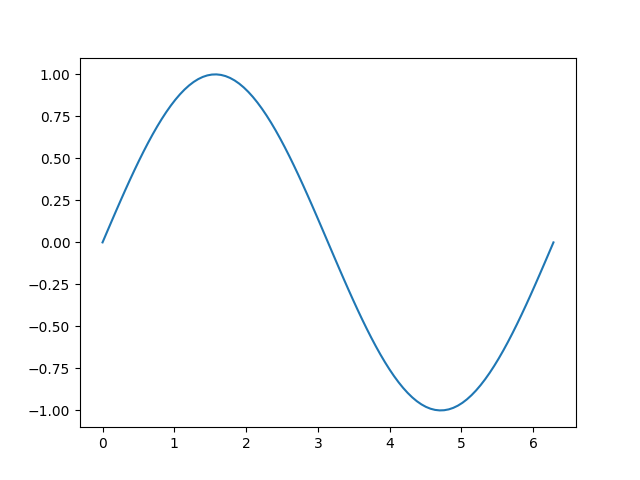

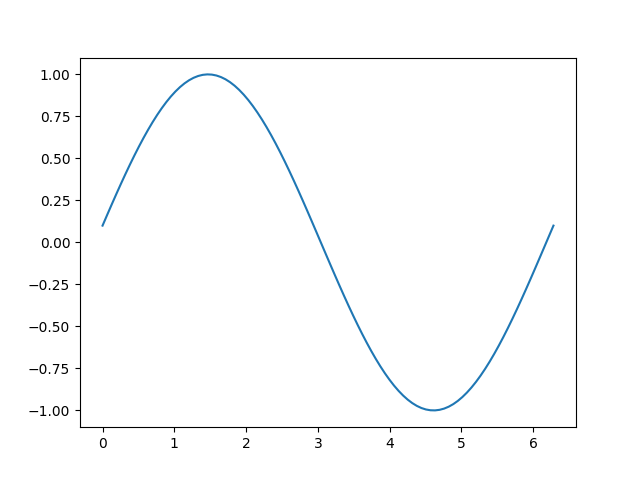

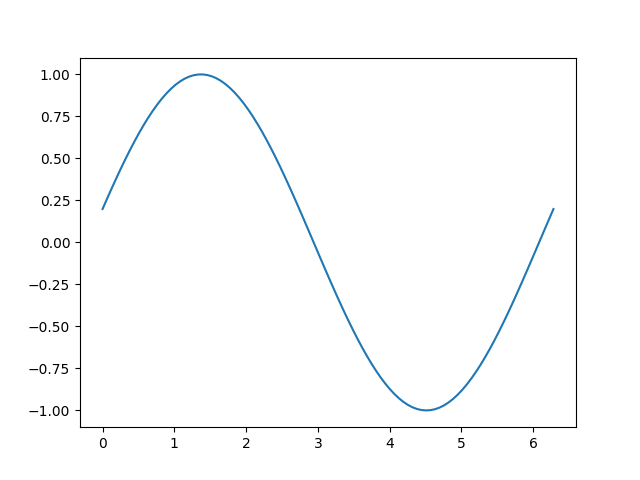

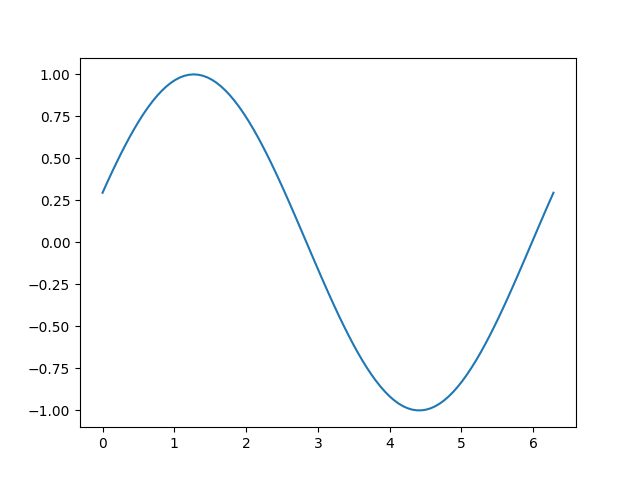

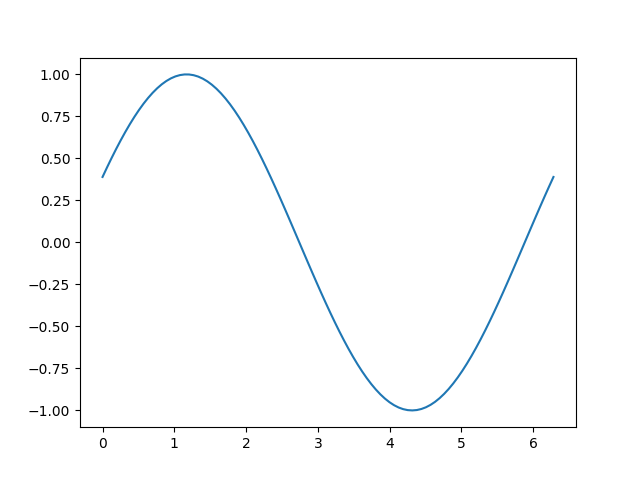

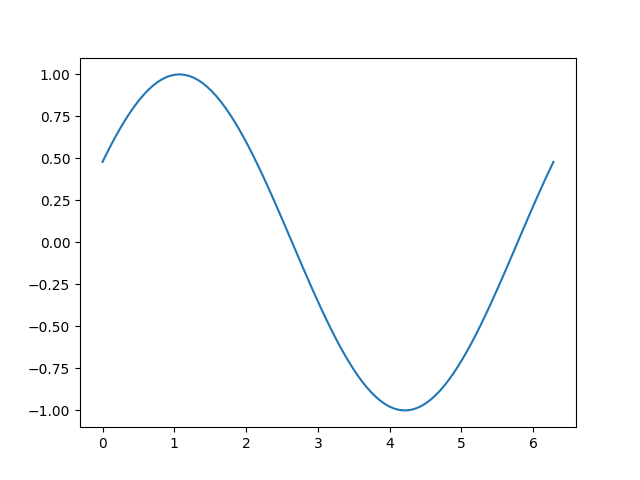

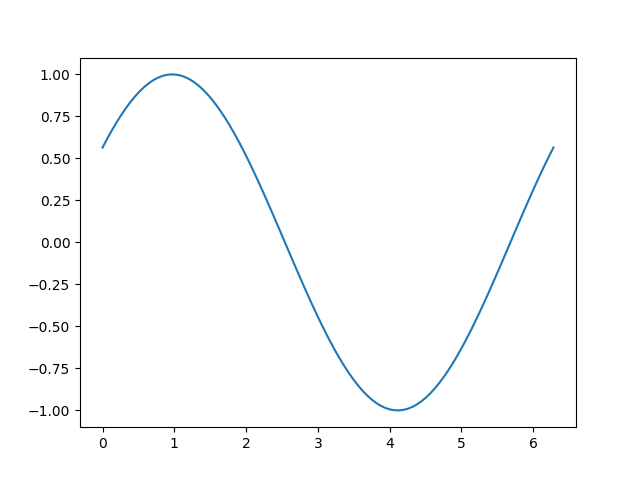

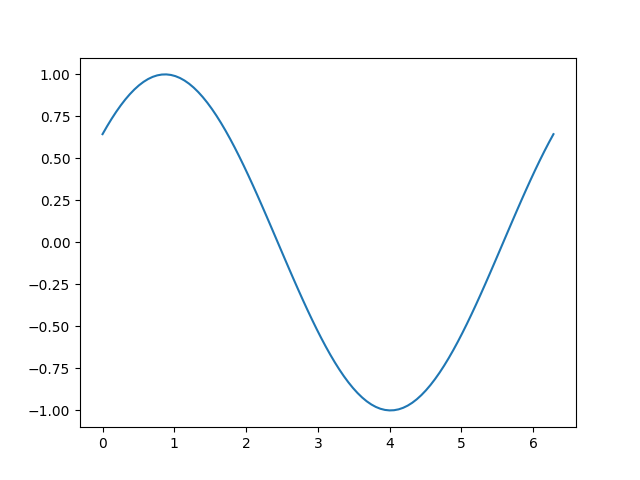

KeyboardInterrupt: 

In [12]:
plt.ion()
x = np.linspace(0, 2 * np.pi, 100)
fig, ax = plt.subplots()
line, = ax.plot(x, np.sin(x))

plt.show()

for i in range(100):
    line.set_ydata(np.sin(x + i / 10.0))  # Update the data
    ax.draw_artist(ax.patch)              # Redraw the background
    ax.draw_artist(line)                  # Redraw the line
    plt.draw()                     # Redraw the canvas
    fig.canvas.flush_events()             # Process UI events
    plt.pause(0.2)                       # Pause briefly to show updates

## Start the Background Processes

In [4]:
def start_background_process(command, stdout_file, stderr_file):
    """Starts a background process and redirects its stdout and stderr to specified files."""
    # Open both files for writing
    stdout_f = open(stdout_file, "w")
    stderr_f = open(stderr_file, "w")

    process = subprocess.Popen(command, shell=True,
                                stdout=stdout_f,
                                stderr=stderr_f)
    logger.debug(f"{command} PID is: {process.pid}")
    return process, stdout_f, stderr_f

# DAQ process
if sys.platform == "win32":
    daq_proc, daq_stdout, daq_stderr = \
        start_background_process("python DAQ_fake.py", "daq_stdout.log", "daq_stderr.log")
else:
    daq_proc, daq_stdout, daq_stderr = \
        start_background_process("python DAQ.py", "daq_stdout.log", "daq_stderr.log")

# GP Update process
gp_proc, gp_stdout, gp_stderr = \
    start_background_process("python GPUpdate.py", "gp_stdout.log", "gp_stderr.log")


## Start the Plotting

<IPython.core.display.Javascript object>


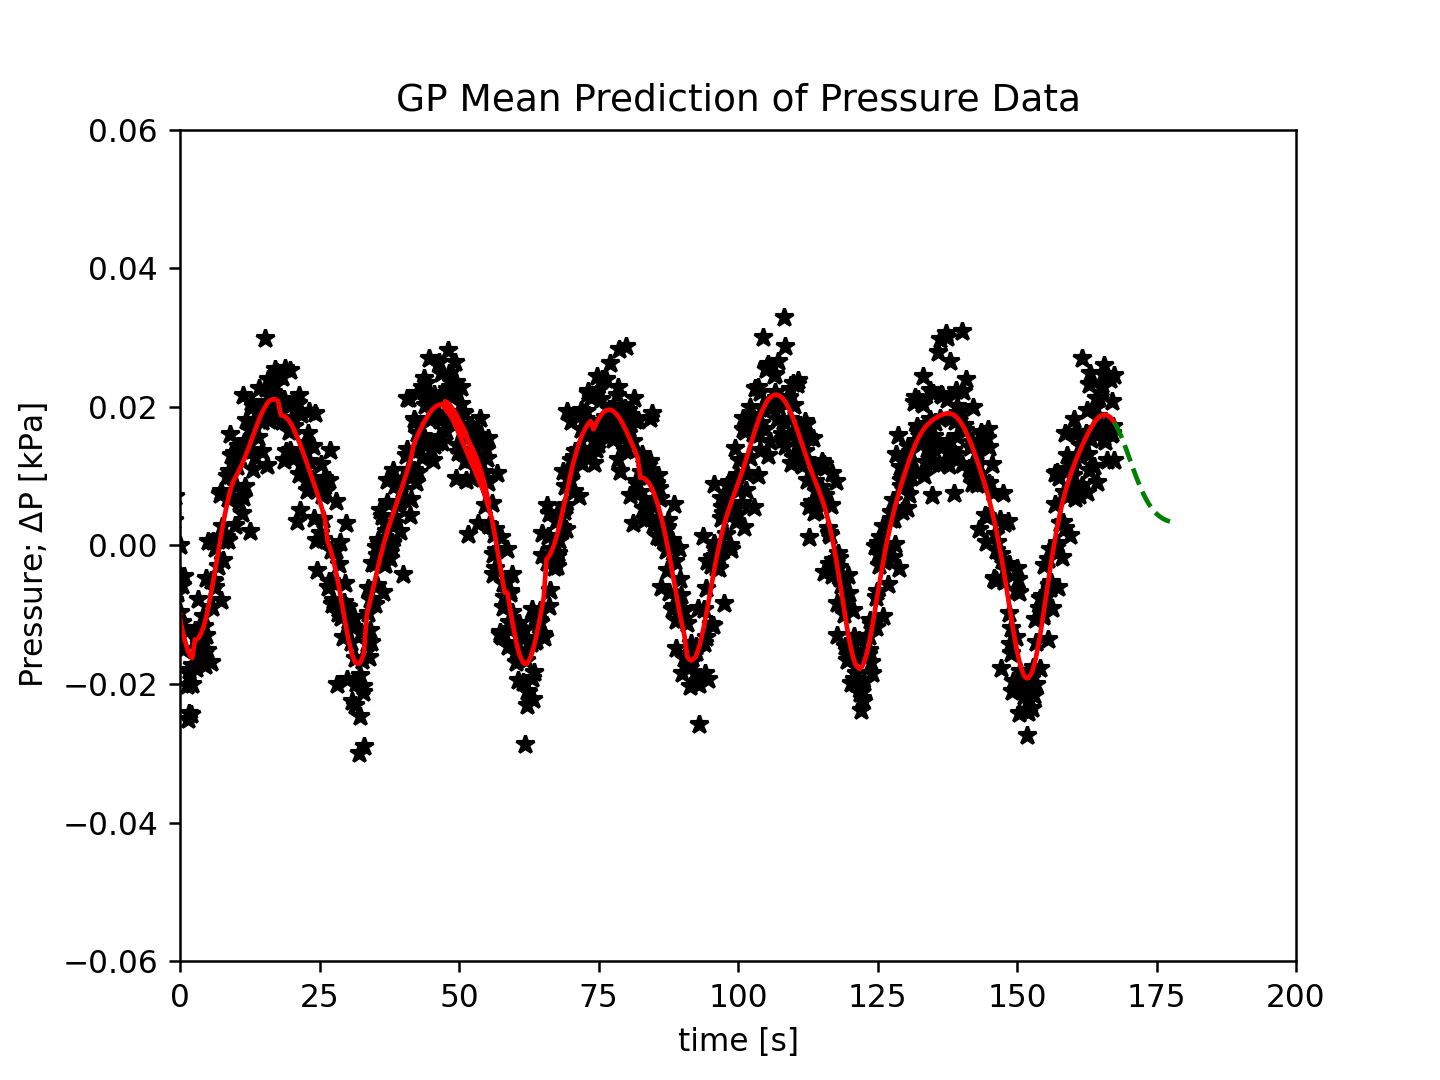

C:\Users\twilkeni\AppData\Local\anaconda3\envs\pytorch-env\site-packages\gpytorch\models\exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [3]:
# Define ExactGPModel
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()  # noqa
        )  # noqa

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# load model from off-line training data
train_x = torch.load("data/train_x.pth")
train_y = torch.load("data/train_y.pth")
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-3),
    noise_prior=gpytorch.priors.NormalPrior(0, 0.1),
)
state_dict = torch.load("data/model_state_start.pth")
model = ExactGPModel(train_x, train_y, likelihood)
model.load_state_dict(state_dict)

PLOT.scheduled_fetch(model, likelihood)

## Kill the Background Processes

In [6]:
def kill_process(process, stdout_f, stderr_f):
    """Kills a process given a subprocess.Popen object."""
    try:
        process.terminate()  # Sends SIGTERM
        process.wait(timeout=5)  # Wait up to 5 seconds for the process to gracefully exit
        stdout_f.close()
        stderr_f.close()
        print("stdout files closed")
    except subprocess.TimeoutExpired:
        process.kill()  # Force kill if not terminated after timeout
        process.wait()  # Wait for the process to be killed
        stdout_f.close()
        stderr_f.close()
        print("stdout files closed")
    except Exception as e:
        print(f"Failed to kill the process: {str(e)}")

kill_process(daq_proc, daq_stdout, daq_stderr)
kill_process(gp_proc, gp_stdout, gp_stderr)

stdout files closed
stdout files closed
